# Machine Learning

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns

## ML as an alternative to hypothesis testing

Let's say you have a model where you estimate the value of connectivity between frontal and temporal lobes and you estimate this model for several Alzheimer subjects and control subjects.
You want to know if there is a difference in the connectivity between the two groups.

The histograms of the two groups might look something like this: 

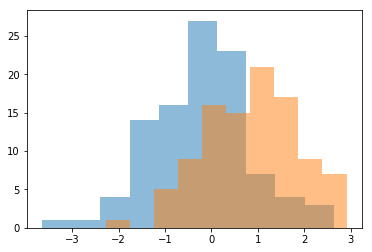

In [141]:
d = 1
s = [1, 1]
n = 100
a = np.random.randn(n, 1) * s[0]
b = np.random.randn(n, 1) * s[1] + d
plt.figure()
plt.hist(a, alpha=0.5)
plt.hist(b, alpha=0.5)
plt.show()

Then in order to test if there is a difference you could run a t-test and check if the difference is statistically significant.

In [142]:
print("p-value = %1.2e" %(ttest_ind(a, b)[1]))

p-value = 2.28e-11


Or you can use the value of the estimated connectivity for each subject to predict the group they belong to.

In [143]:
X = np.vstack([a, b])
y = np.array([0 if i<n else 1 for i in range(2*n)])
model = LogisticRegression()
folds = 5
kf = KFold(n_splits=folds)

score = np.zeros([folds])
i = 0  # counter for repetitions
for train_idx, test_idx in kf.split(X):  # repetitions loop
    model.fit(X[train_idx, :], y[train_idx])
    score[i] = model.score(X[test_idx, :], y[test_idx])
    i+=1
print("classification accuracy = %1.2f" %(score.mean()))

classification accuracy = 0.57


While hypothesis testing and the classification give different informations, what is usually implied in hypothesis testing (especially in more applied/clinical domain) is that the variable (in this case the connectivity) has some information about the groups (labels). 

### Multiple hypothesis testing

When dealing with large scale connectivity a difficult statistical task is the search for those links that are more relevant to distinguish between given groups. This traditionally involves multiple hypothesis testing. ML methods provide alternatives to this that can be more efficient. While this is out of topic for this course you can read more about it here: https://www.biorxiv.org/content/early/2018/02/12/201624

## How to do classification
We are given some data points

$x = [x_1, x_2, \dots, x_m]$

and some classes

$ C_1, C_2$

And we want to assign each point to one class.

The best approach is to choose the class $k$ from which $p(C_k|x)$ is maximum.

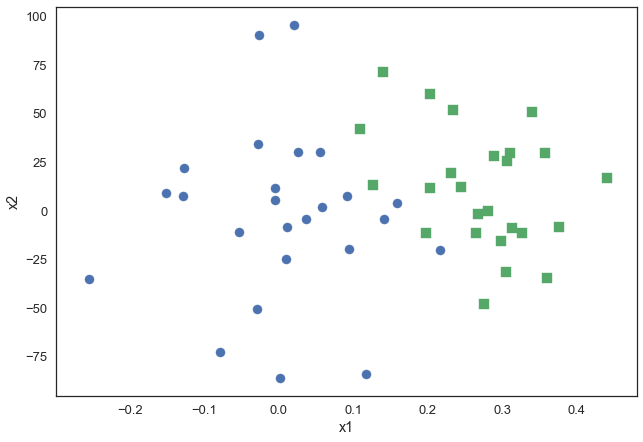

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [264]:
# dataset
N = 50
Nhalf = int(N/2)
x1 = np.random.randn(Nhalf, 2)*[.1, 40]
x2 = np.random.randn(Nhalf, 2)*[.1, 40] + .3
X = np.vstack([x1, x2])
y = np.array([0 if i<Nhalf else 1 for i in range(N)])

plt.figure()
plt.scatter(x1[:, 0], x1[:, 1], marker='o')
plt.scatter(x2[:, 0], x2[:, 1], marker='s')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

model = LogisticRegression()
model.fit(X, y)

## How to evaluate a classifier

### accuracy

In [265]:
print("classifier accuracy: %1.2f" %(model.score(X, y)))

classifier accuracy: 0.90


### Training set has to be separated from test set

What we want to know is how good the classifier is in predicting the class the whole population, i.e. for future samples. 

So we have to evaluate the classifier on data that have not been used for training.

#### k-fold cross validation

k-fold cross-validation generates one partition of the dataset in k subsets. Then it leaves one subset out and uses k-1 subsets to train the model and the one left out to test the trained model. This procedure is repeated until all subsets defined by the initial partion (also called folds) are used as test set. At the end k accuracies will be provided from which the median test-set accuracy can be calculated. k-fold CV requires more computations than a simple split but has the advantage of using all the data points available. The estimation accuracy is then improved. Typical values for k are in the range [3, 10]. The extreme case of k=N, where N is the number of all samples, is called Leave-one-out CV, since in each fold only one sample is left out for testing.

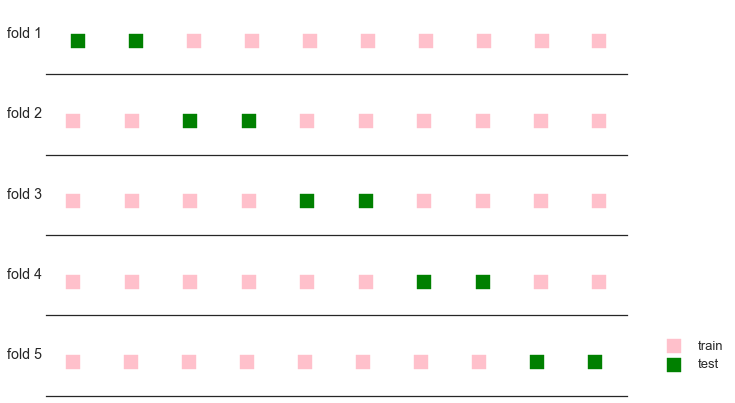

In [262]:
# graphically represents k-fold CV
sns.set_context('talk')
N = 10
X = np.arange(N)
k = 5
kf = KFold(n_splits=k)
fig, ax = plt.subplots(ncols=1, nrows=k)
i = 0
for train, test in kf.split(X):
    ax[i].scatter(X[train], np.repeat(1, len(X[train])), marker='s', s=20000/N**2, c='pink', label='train')
    ax[i].scatter(X[test], np.repeat(1, len(X[test])), marker='s', s=20000/N**2, c='green', label='test')
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    sns.despine(left=True)
    ax[i].set_ylabel('fold %i' %(i+1), rotation=0, ha='right')
    i += 1
ax[i-1].legend(frameon=False, bbox_to_anchor=(1.04, 1))
plt.show()

In [266]:
N = 50
Nhalf = int(N/2)
x1 = np.random.randn(Nhalf, 2)*[.1, 40]
x2 = np.random.randn(Nhalf, 2)*[.1, 40] + .3
X = np.vstack([x1, x2])
y = np.array([0 if i<Nhalf else 1 for i in range(N)])

folds = 5
kf = KFold(n_splits=folds, shuffle=True)

score = np.zeros([folds])
i = 0  # counter for repetitions
for train_idx, test_idx in kf.split(X):  # repetitions loop
    model.fit(X[train_idx, :], y[train_idx])
    score[i] = model.score(X[test_idx, :], y[test_idx])
    i+=1

print("Accuracy: %1.2f +/- %.2f (mean +/- standard deviation)" %(score.mean(), score.std()))     

Accuracy: 0.84 +/- 0.15 (mean +/- standard deviation)


### Comparison of estimated accuracy with chance level

How good is the accuracy of a classifier depends on the accuracy expected by chance.

In [267]:
folds = 5
kf = KFold(n_splits=folds, shuffle=True)
y_rnd = np.random.permutation(y)
model_rnd = LogisticRegression()
score = np.zeros([folds])
score_rnd = np.zeros([folds])
i = 0  # counter for repetitions
for train_idx, test_idx in kf.split(X):  # repetitions loop
    model.fit(X[train_idx, :], y[train_idx])
    model_rnd.fit(X[train_idx, :], y_rnd[train_idx])
    score[i] = model.score(X[test_idx, :], y[test_idx])
    score_rnd[i] = model.score(X[test_idx, :], y_rnd[test_idx])
    i+=1

print("Accuracy: %1.2f +/- %.2f (mean +/- standard deviation)" %(score.mean(), score.std()))     
print("Chance level: %1.2f +/- %.2f (mean +/- standard deviation)" %(score_rnd.mean(), score_rnd.std()))     

Accuracy: 0.76 +/- 0.14 (mean +/- standard deviation)
Chance level: 0.44 +/- 0.14 (mean +/- standard deviation)


### Leave-one-out

Typically LOOCV has high variance as an estimator of performance and is therefore not suggested. For the same reason in small datasets values of k between [3, 5] are suggested. 

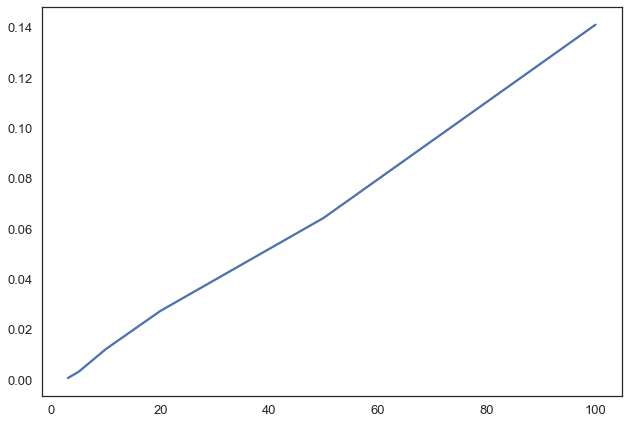

In [268]:
# show increase of variance with k
N = 100
X, y = make_classification(n_samples=N, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           weights=[0.5, 0.5], n_clusters_per_class=1,
                           class_sep=0.4, random_state=8)

ks = [3, 5, 10, 20, 50, N]
var = np.zeros(len(ks))
# cross-validation
for j, k in enumerate(ks):
    shS = KFold(n_splits=k)
    score = np.zeros([k])
    i = 0
    for train_idx, test_idx in shS.split(X):
        data_train = X[train_idx, :]
        y_train = y[train_idx]
        data_test = X[test_idx, :]
        y_test = y[test_idx]
        clf = KNeighborsClassifier(n_neighbors=1).fit(data_train, y_train)
        score[i] = clf.score(data_test, y_test)
        i += 1
    var[j] = np.var(score)
plt.figure()
plt.plot(ks, var)
plt.show()

Since for these values of k only few estimations of the performance are available random permutations CV can be used. With this method a random selection of all samples of a given size N can be left out for the test set and all other samples used for the training set. This procedure can be repeated many times to get a good estimation of the performance. The method is also called "shuffle & split", since data can be first shuffled and then split into training and test set.

### Shuffle and split

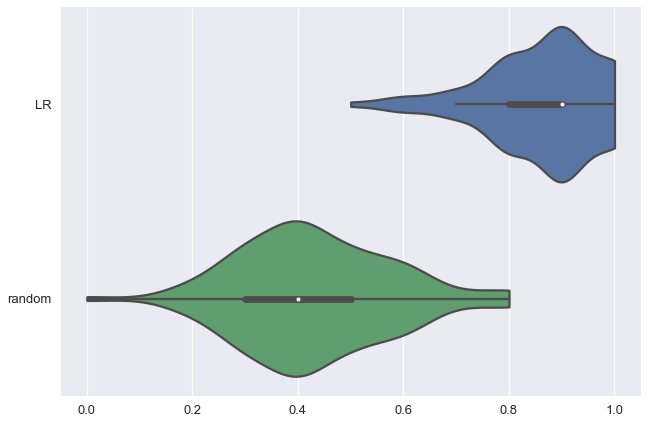

In [229]:
repetitions = 100
shS = ShuffleSplit(n_splits=repetitions, test_size=0.2, random_state=None)
score = np.zeros([repetitions])
score_rnd = np.zeros([repetitions])
i = 0
for train_idx, test_idx in shS.split(X):
    model.fit(X[train_idx, :], y[train_idx])
    model_rnd.fit(X[train_idx, :], y_rnd[train_idx])
    score[i] = model.score(X[test_idx, :], y[test_idx])
    score_rnd[i] = model.score(X[test_idx, :], y_rnd[test_idx])
    i += 1
    
# plot comparison as violin plots
sns.set_context('talk')
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
sns.violinplot(data=[score, score_rnd], cut=0, orient='h', scale='width', ax=ax)
ax.set_yticklabels(['LR', 'random'])
plt.show()

### Unbalanced classes

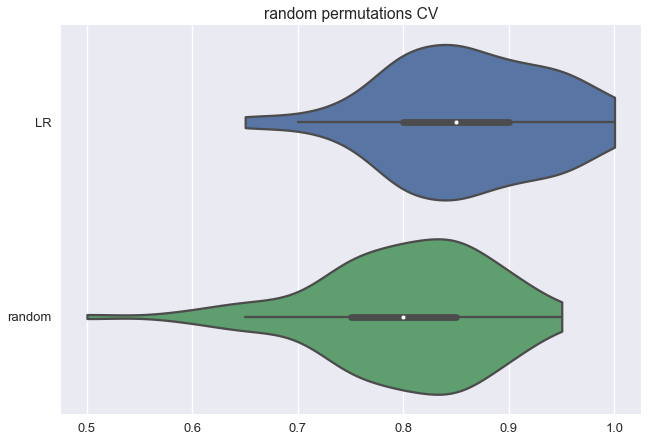

In [233]:
X, y = make_classification(n_samples=100, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           weights=[0.2, 0.8], n_clusters_per_class=1,
                           class_sep=0.5, random_state=0)
#yR = y[np.random.permutation(len(y))]
yR = np.random.permutation(y)
clf = LogisticRegression(C=10000, penalty='l2', solver='lbfgs')
#clf = KNeighborsClassifier(n_neighbors=1)
clfR = LogisticRegression(C=10000, penalty='l2', solver='lbfgs')
#clfR = KNeighborsClassifier(n_neighbors=1)
repetitions = 100
shS = ShuffleSplit(n_splits=repetitions, test_size=0.2, random_state=None)
score = np.zeros([repetitions])
scoreR = np.zeros([repetitions])
i = 0
for train_idx, test_idx in shS.split(X):
    data_train = X[train_idx, :]
    y_train = y[train_idx]
    data_test = X[test_idx, :]
    y_test = y[test_idx]
    clf.fit(data_train, y_train)
    clfR.fit(data_train, yR[train_idx])
    score[i] = clf.score(data_test, y_test)
    scoreR[i] = clfR.score(data_test, yR[test_idx])
    i += 1

# plot comparison as violin plots
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
sns.violinplot(data=[score, scoreR], cut=0, orient='h', scale='width', ax=ax)
ax.set_yticklabels(['LR', 'random'])
ax.set_title('random permutations CV')
plt.show()

### Sensitivity and specificity

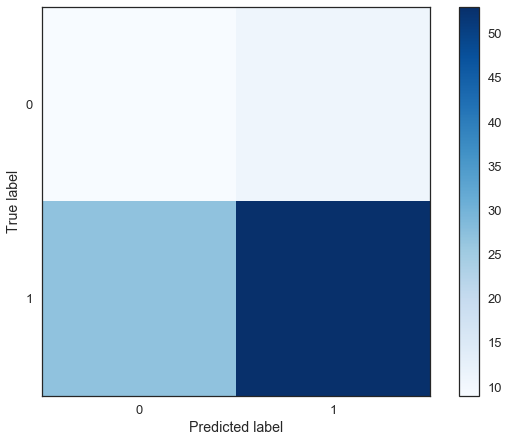

In [242]:
CM = confusion_matrix(y_true=y, y_pred=model.predict(X))
with sns.axes_style('white'):
    plt.figure()
    plt.imshow(CM, cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks([0, 1], [0, 1])
    plt.yticks([0, 1], [0, 1])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Data transformations

Until now we have seen simple classification based on "raw" data. Actually it is common to apply some transformations to data in order to boost the performance of the classifier.
Typical transformations include (but not limited to) normalization and dimensionality reduction.

Here we see how to perform standardization of data (useful when features have different scales).

The most import message about transformations is that all transformation parameters have to be estimated only on the training set (not on the whole dataset). 

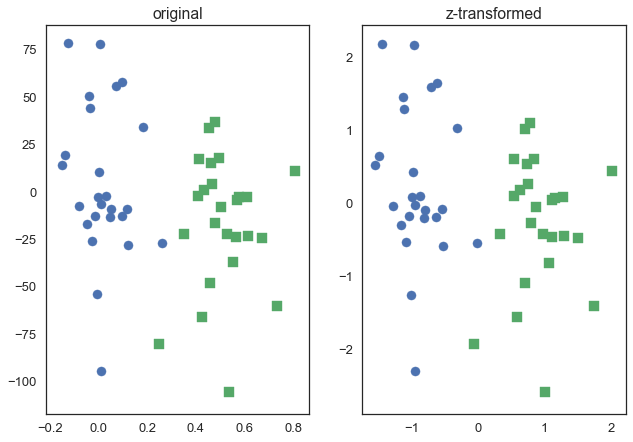

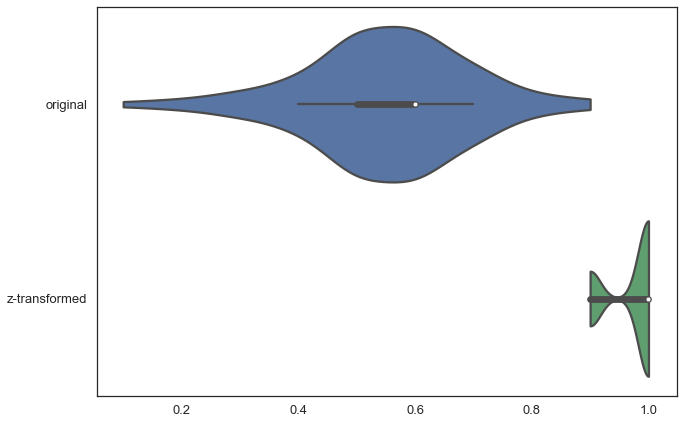

In [269]:
# dataset
N = 50
Nhalf = int(N/2)
x1 = np.random.randn(Nhalf, 2)*[.1, 40]
x2 = np.random.randn(Nhalf, 2)*[.1, 40] + .5
X = np.vstack([x1, x2])
y = np.array([0 if i<Nhalf else 1 for i in range(N)])

scaler = StandardScaler()
Xscaled = scaler.fit_transform(X)

plt.figure()
plt.subplot(1,2,1)
plt.scatter(x1[:, 0], x1[:, 1], marker='o')
plt.scatter(x2[:, 0], x2[:, 1], marker='s')
plt.title('original')
plt.subplot(1,2,2)
plt.scatter(Xscaled[:Nhalf, 0], Xscaled[:Nhalf, 1], marker='o')
plt.scatter(Xscaled[Nhalf:, 0], Xscaled[Nhalf:, 1], marker='s')
plt.title('z-transformed')

model = LogisticRegression()
pipe = Pipeline([('clf', model)])
pipeS = Pipeline([('zscore', StandardScaler()), 
                         ('clf', model)])

repetitions = 100
shS = ShuffleSplit(n_splits=repetitions, test_size=0.2, random_state=None)

score = np.zeros([repetitions])
scoreS = np.zeros([repetitions])
i = 0  # counter for repetitions
for train_idx, test_idx in shS.split(X):  # repetitions loop
    pipe.fit(X[train_idx, :], y[train_idx])
    pipeS.fit(X[train_idx, :], y[train_idx])
    score[i] = pipe.score(X[test_idx, :], y[test_idx])
    scoreS[i] = pipeS.score(X[test_idx, :], y[test_idx])
    i+=1

# plot comparison as violin plots
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
sns.violinplot(data=[score, scoreS], cut=0, orient='h', scale='width', ax=ax)
ax.set_yticklabels(['original', 'z-transformed'])
plt.show()

## Overfitting

When models are too complex (too many degrees of freedom) compared to the constraints imposed by data they tend to overfit, i. e. perfectly adjust to the training data, thereby fitting the noise, which in turn produces low performance on new data (where the noisy realizations are different).

We see here an example of overfitting for kNN classifier where a small value of $k$ give a more complex model.

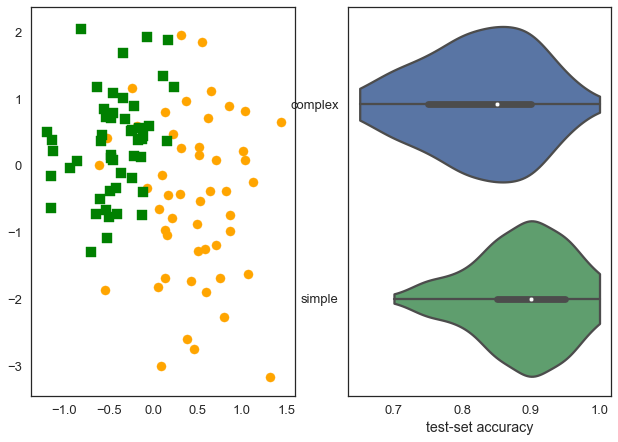

In [248]:
X, y = make_classification(n_samples=100, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           weights=[0.5, 0.5], n_clusters_per_class=1,
                           class_sep=0.4, random_state=8)
# plot data
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].scatter(X[y==0, 0], X[y==0, 1], marker='o', c='orange')
ax[0].scatter(X[y==1, 0], X[y==1, 1], marker='s', c='green')
# models
clf_complex = KNeighborsClassifier(n_neighbors=1)
clf_simple = KNeighborsClassifier(n_neighbors=10)
# show decision boundary for whole dataset
clf_complex.fit(X, y)
clf_simple.fit(X, y)
# cross-validation
repetitions = 100
shS = ShuffleSplit(n_splits=repetitions, test_size=0.2, random_state=0)
scoreC = np.zeros([repetitions])
scoreS = np.zeros([repetitions])
i = 0
for train_idx, test_idx in shS.split(X):
    data_train = X[train_idx, :]
    y_train = y[train_idx]
    data_test = X[test_idx, :]
    y_test = y[test_idx]
    clf_complex.fit(data_train, y_train)
    clf_simple.fit(data_train, y[train_idx])
    scoreC[i] = clf_complex.score(data_test, y_test)
    scoreS[i] = clf_simple.score(data_test, y[test_idx])
    i += 1

# plot comparison as violin plots
sns.violinplot(data=[scoreC, scoreS], cut=0, orient='h', scale='width', ax=ax[1])
ax[1].set_yticklabels(['complex', 'simple'])
ax[1].set_xlabel('test-set accuracy')
plt.show()
